# Loan repayment

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#import scipy


import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import os, sys, json

from sklearn.preprocessing import  StandardScaler , OneHotEncoder 


from sklearn.linear_model import LinearRegression,  SGDRegressor, Ridge, RidgeCV

# from sklearn.model_selection import train_test_split #cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold, LeaveOneOut, cross_validate
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# #from sklearn import metrics

# from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, StackingClassifier

from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, roc_curve, roc_auc_score, f1_score, median_absolute_error, PredictionErrorDisplay

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
 
#from models.models import ModelSequential

import optuna
import pickle

# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

#!pip freeze > requirements.txt

In [322]:
from utils.config_reader import config_reader
from utils.functions import get_professions, get_comparison, get_ROC_plot,get_sigma_limits, get_descr, get_purpose, annotate_scatterplot
from utils.models_utils import f1, callbacks


# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
from optuna.samplers import TPESampler
sampler = TPESampler(seed=random_seed) # fix random seed

## Read files

In [323]:
#features_dscr = pd.read_excel('../data/Features.xlsx') #
#features_dscr

In [324]:
# df = pd.read_csv('../data/accepted_2007_to_2018Q4.csv.gz')
# # df

# sample = df.sample(n=100000 , axis=0, random_state=random_seed)
# #display(sample)
# sample.to_csv('../data/sample_all_features.zip') 

In [325]:
# Reading the sample of 100,000 entries
data_orig = pd.read_csv('../data/sample_all_features.zip', index_col=0) #sample.zip
data_orig = data_orig.sample(100000)
#data_orig.drop(['Unnamed: 0', 'id'], axis=1, inplace=True) #'member_id'

# # Reading whole dataset
# data_orig = pd.read_csv('../data/accepted_2007_to_2018Q4.csv.gz')
#data_orig.drop([2260699, 2260700], axis=0, inplace=True)
#data_orig = data_orig.sample(200000)
#data_orig.to_csv('../data/sample_all_features.zip')
# data_orig.tail()

Read feature description.

In [326]:
# data_orig.drop(['Unnamed: 0'], axis=1, inplace=True)'member_id'
# data_orig.isna().sum().value_counts()

In [327]:
data_orig.shape

(100000, 149)

In [328]:
data_orig.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,...,settlement_date,settlement_amount,settlement_percentage,settlement_term
782893,25000.0,25000.0,25000.0,36 months,...,NaN,NaN,NaN,NaN
1769837,20000.0,20000.0,20000.0,36 months,...,NaN,NaN,NaN,NaN
1400202,8500.0,8500.0,8500.0,36 months,...,NaN,NaN,NaN,NaN
1309910,18000.0,18000.0,17950.0,60 months,...,NaN,NaN,NaN,NaN
1027922,14000.0,14000.0,14000.0,36 months,...,NaN,NaN,NaN,NaN


# 0. Dataset preparation

In [329]:
#data_orig.columns.to_list()

In [330]:
# num_features, cat_features = [s for s in data_orig.columns if data_orig[s].dtypes != 'object'], [s for s in data_orig.columns if data_orig[s].dtypes == 'object']
# #cat_features

In order to do feature analysis we should select features which might affect the target.

In [331]:
data_orig.shape

(100000, 149)

### All features

In [332]:
selected_cols = [
    'loan_amnt', 'delinq_amnt',  'total_pymnt',
 'term', 'int_rate', 'installment',  'last_pymnt_d','last_pymnt_amnt', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'chargeoff_within_12_mths',\
    'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status','pymnt_plan',\
    'purpose','title','dti','earliest_cr_line','open_acc','pub_rec','revol_bal',\
    'revol_util','total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies',\
    
] #settlement_percentage, 'mths_since_last_delinq', ,'hardship_length','total_bal_il','total_rec_prncp', 'total_rec_int', 'funded_amnt','hardship_flag', 'dti'

# other_columns = ['loan_status', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',\
#        'sub_grade', 'emp_title', 'emp_length', 'home_ownership',\
#        'verification_status', 'pymnt_plan', 'url', 'purpose', 'title',\
#        'zip_code', 'addr_state',  'delinq_2yrs', 'earliest_cr_line',\
#        'fico_range_low', 'fico_range_high', 'inq_last_6mths',\
#        'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',\
#        'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',\
#        'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',\
#        'total_rec_int', 'total_rec_late_fee', 'recoveries',\
#        'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',\
#        'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low',\
#        'collections_12_mths_ex_med', 'policy_code', 'application_type',\
#        'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',\
#        'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',\
#        'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',\
#        'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',\
#        'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',\
#        'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',\
#        'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',\
#        'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',\
#        'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',\
#        'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tax_liens', 'tot_hi_cred_lim',\
#        'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',\
#        'hardship_flag', 'disbursement_method', 'debt_settlement_flag',\
#        'issued_year', 'annual_inc_log', 'pub_rec_bankruptcies'] #'dti'
 

data = data_orig #[selected_cols]
#data.to_csv('../data/sample1.zip')
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,...,settlement_date,settlement_amount,settlement_percentage,settlement_term
782893,25000.0,25000.0,25000.0,36 months,...,NaN,NaN,NaN,NaN
1769837,20000.0,20000.0,20000.0,36 months,...,NaN,NaN,NaN,NaN
1400202,8500.0,8500.0,8500.0,36 months,...,NaN,NaN,NaN,NaN
1309910,18000.0,18000.0,17950.0,60 months,...,NaN,NaN,NaN,NaN
1027922,14000.0,14000.0,14000.0,36 months,...,NaN,NaN,NaN,NaN


In [333]:
data['pub_rec_bankruptcies'].value_counts()

0.0    87881
1.0    11452
2.0      452
3.0      115
4.0       27
5.0       14
6.0        2
7.0        1
8.0        1
Name: pub_rec_bankruptcies, dtype: int64

In [334]:
# fig = plt.figure(figsize=(10,5))
# matrix = np.triu(data.corr(numeric_only=True))
# sns.heatmap(round(abs(data.corr(numeric_only=True)), 2), annot=True, fmt='.1g', linewidths=.5, cmap= 'coolwarm', mask=matrix)

# 1. EDA

### Loan_status (target feature)

There are several loan repayment outcomes which can be used as targets.

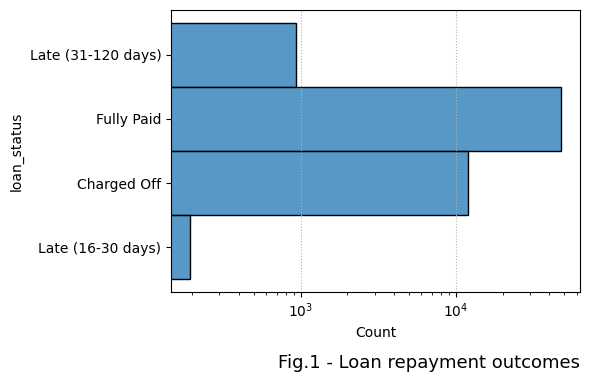

In [387]:
fig, ax = plt.subplots(figsize=(6, 4))
fig = sns.histplot(data, y='loan_status')
fig.set_title('Fig.1 - Loan repayment outcomes', y=-0.3, fontsize=13, loc='right')
ax.set_xscale('log')

plt.tight_layout()
ax.xaxis.grid(linestyle=':')
plot_counter=1
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

To simplify the task let us exclude customers who either do not meet the credit policy or who are in the grace period.

In [336]:
data['loan_status'].value_counts(True)

Fully Paid                                             0.47896
Current                                                0.38550
Charged Off                                            0.11940
Late (31-120 days)                                     0.00927
In Grace Period                                        0.00379
Late (16-30 days)                                      0.00193
Does not meet the credit policy. Status:Fully Paid     0.00075
Does not meet the credit policy. Status:Charged Off    0.00034
Default                                                0.00006
Name: loan_status, dtype: float64

In [337]:
current = data.query("loan_status in ['Current']")
data = data.query("loan_status in ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)']") #'Current',

In [386]:
data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       ...
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term',
       'issued_year', 'annual_inc_log'],
      dtype='object', length=150)

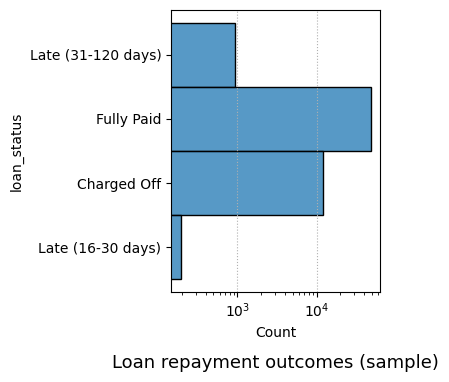

In [338]:
fig, ax = plt.subplots(figsize=(4, 4))
fig = sns.histplot(data, y='loan_status')
fig.set_title('Loan repayment outcomes (sample)', y=-0.3, fontsize=13)
ax.set_xscale('log')

plt.tight_layout()
ax.xaxis.grid(linestyle=':')
plot_counter=1
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [339]:
# data = data[['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', \
#     'emp_title', 'emp_length','loan_status']]

### issue_d

In [340]:
get_descr('issue_d')

The month which the loan was funded


In [341]:
data['issue_d']

782893     Sep-2018
1769837    Nov-2013
1400202    Nov-2018
1309910    Mar-2014
             ...   
1093341    Jan-2016
1027980    Mar-2016
1757944    Dec-2013
123199     Oct-2015
Name: issue_d, Length: 60956, dtype: object

In [342]:
data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.date
data['issued_year'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.year
# data['issued_month'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.month

In [343]:
new_order = list(np.sort(data['issue_d'].unique()))
print('Number of unique categories: ', len(new_order))
temp1 = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
temp2 = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')]

Number of unique categories:  135


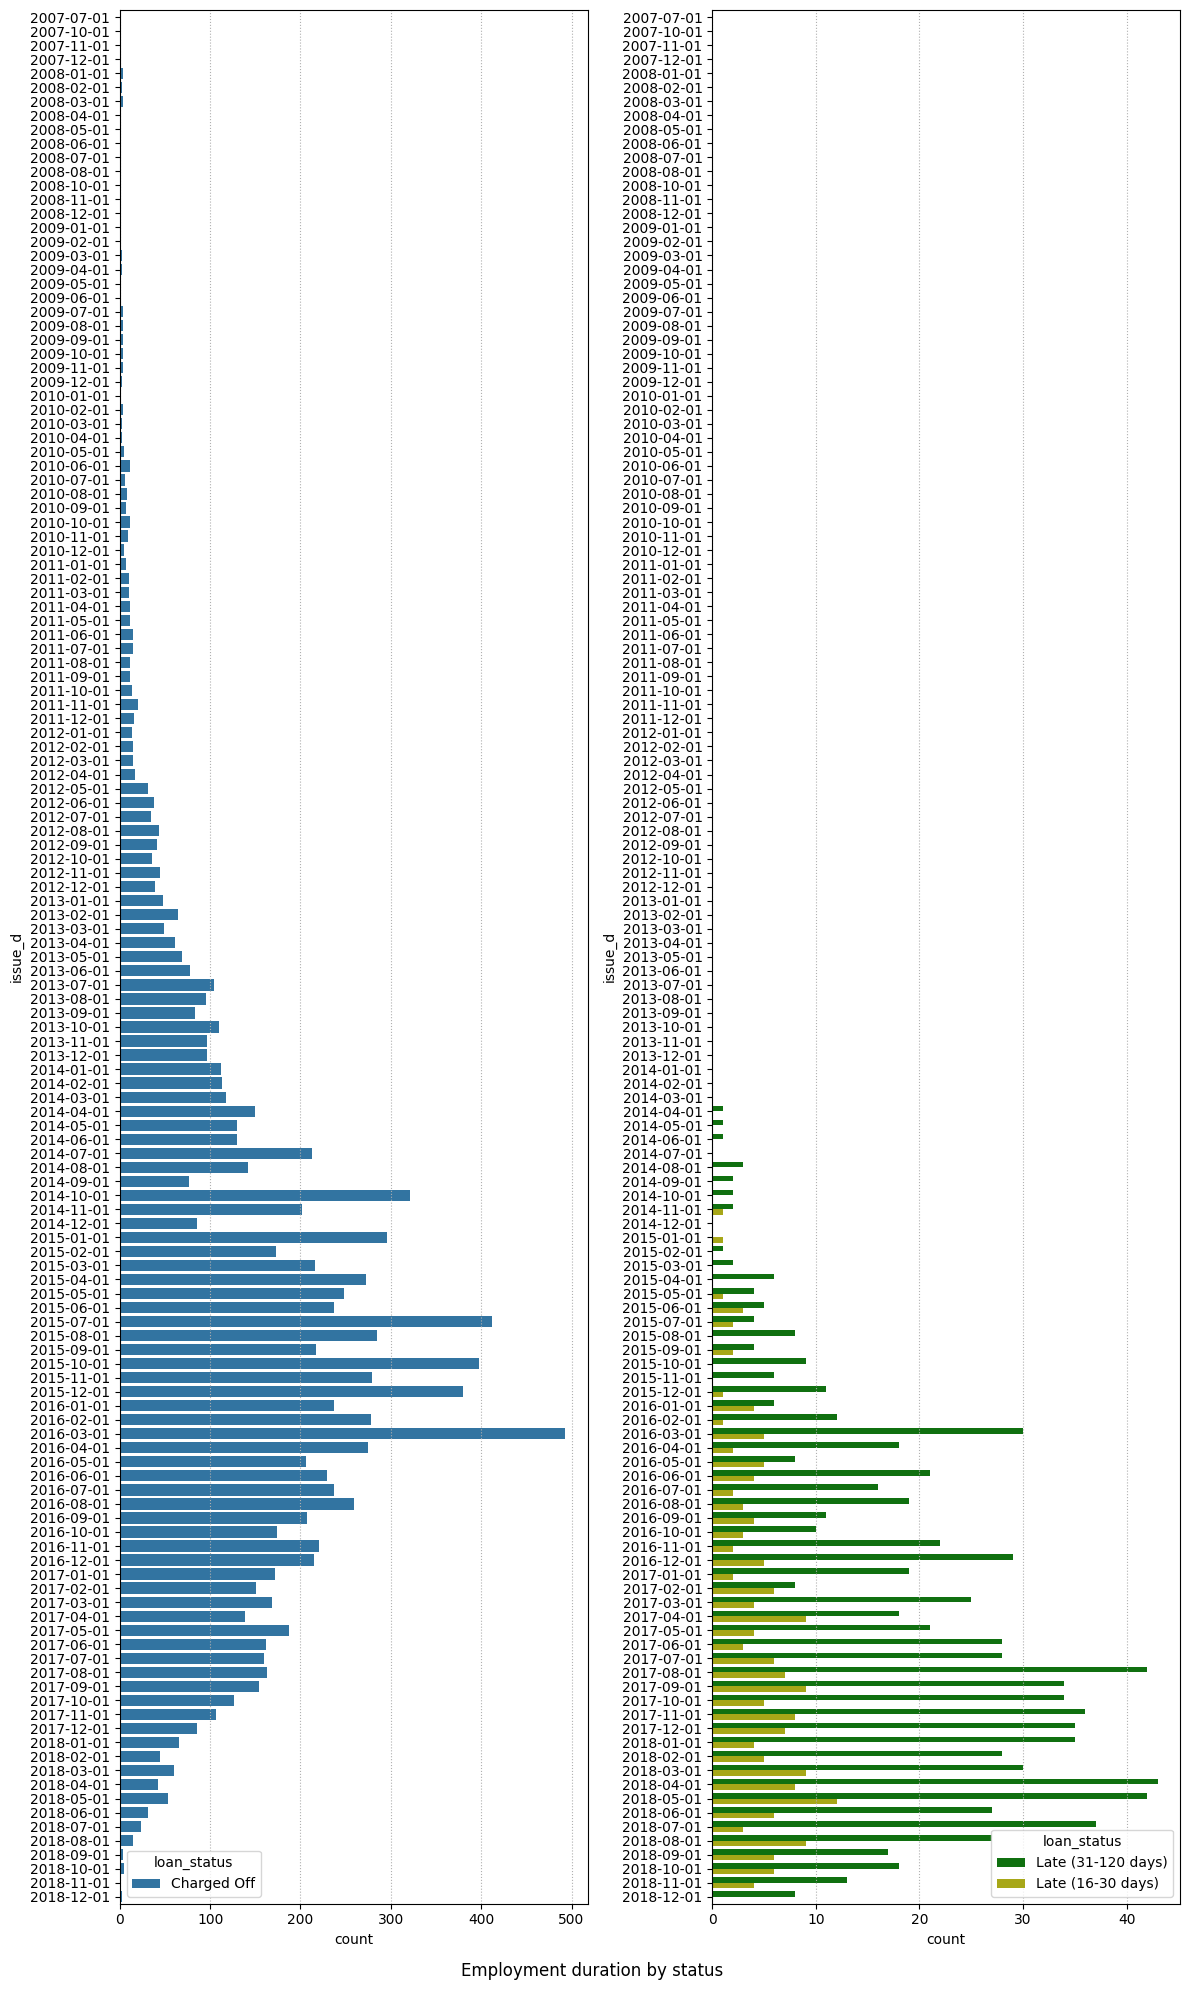

In [344]:
#fig_id=4

fig, ax = plt.subplots(1,2, figsize=(12, 20))
fig = sns.countplot(data=data[data['loan_status']=='Charged Off'], y='issue_d', hue='loan_status', ax=ax[0], order=new_order) #, palette=['b','r']width=0.5,
ax[0].xaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

fig = sns.countplot(data=temp2, y='issue_d', hue='loan_status',  ax=ax[1], palette=['g','y'], order=new_order) #width=0.5,
ax[1].xaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Employment duration by status ', y=-0.0) #Fig.{fig_id} - 
#ax.set_yscale('log');
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

In [345]:
# #fig_id=4

# fig, ax = plt.subplots(1,2, figsize=(10, 4))
# fig = sns.countplot(data=temp1, x='issued_year', hue='loan_status', width=0.5, ax=ax[0]) #, palette=['b','r']
# ax[0].yaxis.grid(linestyle=':')
# #ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)
# ax[0].tick_params(axis='x', rotation=30)
               
# fig = sns.countplot(data=temp2, x='issued_year', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
# ax[1].yaxis.grid(linestyle=':')
# #ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

# plt.suptitle(f' Employment duration by status ', y=-0.0) #Fig.{fig_id}
# #ax.set_yscale('log');
# plt.tight_layout()

In [346]:
mask_paid = data['loan_status']=='Fully Paid'
mask_charged = data['loan_status']=='Charged Off'
mask_overdue = (data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')
 

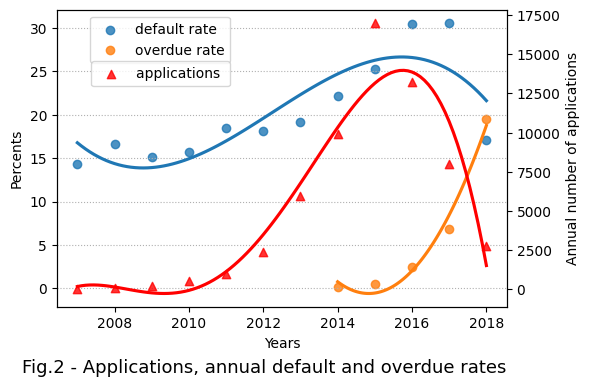

In [347]:
repaid = data[mask_paid].groupby(['issued_year'])['loan_status'].count()
default = data[mask_charged].groupby(['issued_year'])['loan_status'].count()
overdue = data[mask_overdue].groupby(['issued_year'])['loan_status'].count()
applications = data.groupby(['issued_year'])['loan_status'].count()

#default_rates = default / repaid
#overdue_rate = overdue / repaid

rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})
app =  pd.DataFrame({'applications': applications})

plot_counter = 2
fig, ax = plt.subplots(figsize=(6, 4))

sns.regplot(rates, x=rates.index, y='default rate', order=3, ci=None, label='default rate') #, markers='o'
sns.regplot(rates, x=rates.index, y='overdue rate', order=2, ci=None, label='overdue rate')
ax.set_xlabel('Years')
ax.set_ylabel('Percents')
ax.yaxis.grid(linestyle=':')

ax2 = ax.twinx() 
ax2 = sns.regplot(app, x=app.index, y=app.values, order=4, ci=None, marker='^', color='red', label='applications ') #'-o' color='red',, size=35
ax2.set_ylabel('Annual number of applications')
#ax2.set_yscale('log')
ax.set_title(f'Fig.{plot_counter} - Applications, annual default and overdue rates', y=-0.25, fontsize=13, loc='right')
ax.legend(bbox_to_anchor=(0.4, 1))
ax2.legend(bbox_to_anchor=(0.4, 0.85))
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [348]:
# delete unnesessairy feature
data.drop(['issue_d'],axis=1, inplace=True)

### grade and sub_grade

In [349]:
get_descr('grade')
get_descr('sub_grade')

LC assigned loan grade
LC assigned loan subgrade


In [350]:
data['grade'].value_counts(True)

B    0.293901
C    0.284369
A    0.169827
D    0.151667
E    0.069411
F    0.023870
G    0.006956
Name: grade, dtype: float64

In [351]:
data[['grade','sub_grade']]

,grade,sub_grade
782893,E,E4
1769837,A,A4
1400202,B,B2
1309910,E,E2
...,...,...
1093341,A,A1
1027980,B,B3
1757944,E,E3
123199,F,F2


In [352]:
# comparisson of 2 features
data['grade'].compare(data['sub_grade'].astype(str).str[0])

,self,other


> Grades matches with 1st letters of subgrades 

Number of unique categories:  35


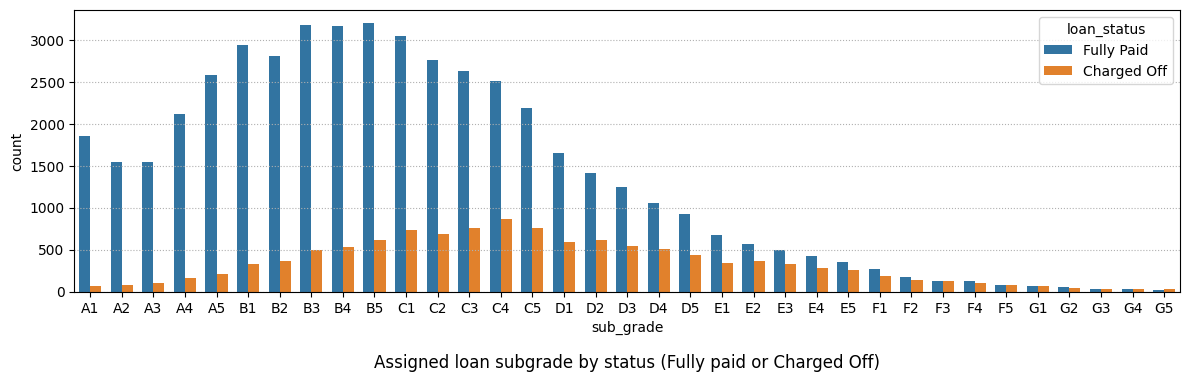

In [353]:
new_order = list(np.sort(data['sub_grade'].unique()))
print('Number of unique categories: ', len(new_order))
temp = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
fig_id=2

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(data=temp, x='sub_grade', hue='loan_status', width=0.7, order=new_order)
ax.yaxis.grid(linestyle=':')
ax.set_title(f'Assigned loan subgrade by status (Fully paid or Charged Off)', y=-0.3);
#ax.set_yscale('log');
plt.tight_layout()

In [354]:
# new_order = list(np.sort(data['grade'].unique()))
# print('Number of unique categories: ', len(new_order))
# temp1 = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
# temp2 = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')]
# fig_id=2

# fig, ax = plt.subplots(1,2, figsize=(10, 4))
# sns.countplot(data=temp1, x='grade', hue='loan_status', width=0.7, ax=ax[0], order=new_order) #, palette=['b','r']
# ax[0].yaxis.grid(linestyle=':')
# ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

# ax[1] = sns.countplot(data=temp2, x='grade', hue='loan_status', width=0.7, order=new_order, palette=['g','y'])
# ax[1].yaxis.grid(linestyle=':')
# ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)
# plot_counter = 2
# plt.suptitle(f' Assigned loan grade by status ', y=0.05) #Fig.{plot_counter} -
# #ax.set_yscale('log');
# plt.tight_layout()

# #plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

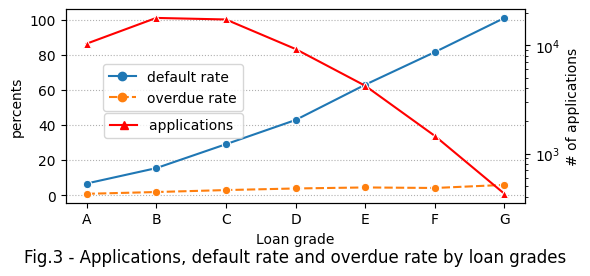

In [355]:
repaid =  data[mask_paid].groupby(['grade'])['loan_status'].count()
default = data[mask_charged].groupby(['grade'])['loan_status'].count()
overdue = data[mask_overdue].groupby(['grade'])['loan_status'].count()
applications = data.groupby(['grade'])['loan_status'].count()

rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})
app =  pd.DataFrame({'applications ': applications})

plot_counter = 3
fig, ax = plt.subplots(1,1, figsize=(6, 3))

sns.lineplot(rates, markers='o')
ax.set_xlabel('Loan grade')
ax.set_ylabel('percents')
#ax.set_yscale('log')
ax.yaxis.grid(linestyle=':')
#plt.title('Title', fontsize=17,  position=(0.5,0.85))

ax2 = ax.twinx() 
ax2 = sns.lineplot(app, markers='^', palette=['r'])
#a2.set_xlabel('Loan grade')
ax2.set_ylabel('# of applications')
ax2.set_yscale('log')

#ax.yaxis.grid(linestyle=':')
ax.set_title(f'Fig.{plot_counter} - Applications, default rate and overdue rate by loan grades', y=-0.35)

ax.legend(bbox_to_anchor=(0.4, .75))
ax2.legend(bbox_to_anchor=(0.4, 0.5));
plt.tight_layout();
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

> Although the 'sub_grade' feature categorises loans more precise than 'grade', the latter feature represents the trend more consizely, and, therefore, histograms will be shorter. 

In [356]:
# fig, ax = plt.subplots(1,2, figsize=(13, 4.5))
# plt.subplots_adjust(wspace=0.3)
# sns.boxplot(data=temp1, x='grade', y='loan_amnt', hue='loan_status', width=0.7, ax=ax[0], order=new_order) #, palette=['b','r']
# ax[0].yaxis.grid(linestyle=':')
# ax[0].set_title('Status: Fully paid or Charged Off', y=-0.25)
# major_ticks = np.linspace(0, 40000, 5)
# ax[0].set_yticks(major_ticks)

# ax[0].legend(loc=(1.1,0.75))

# ax[1] = sns.boxplot(data=temp2, x='grade', y='loan_amnt', hue='loan_status', width=0.7, order=new_order, palette=['g','y'])
# ax[1].yaxis.grid(linestyle=':')
# ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.25)
# ax[1].set_yticks(major_ticks)
# ax[1].legend(loc=(1.1,0.75))

# #plot_counter = 3
# plt.suptitle(f'Loan amounts by grades and status', y=0.05)#Fig.{plot_counter} - 
# plt.tight_layout()

# #plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [357]:
#data.drop('grade', axis=1, inplace=True)

Customers with lower loan grade repay loans more often in contrast to those with higher loan grades.

### term

In [358]:
data['term'].value_counts(True)

 36 months    0.7563
 60 months    0.2437
Name: term, dtype: float64

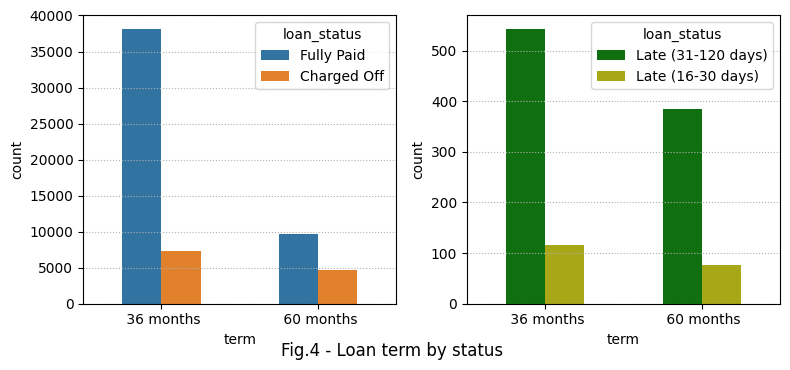

In [359]:
plot_counter = 4
order = [' 36 months',' 60 months']
fig, ax = plt.subplots(1,2, figsize=(8, 4))
fig = sns.countplot(data=temp1, x='term', hue='loan_status', width=0.5, ax=ax[0])  

ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)
#major_ticks = np.linspace(0, 40000, 5)
#ax[0].set_yticks(major_ticks)

fig = sns.countplot(data=temp2, x='term', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'], order=order)
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)
#major_ticks = np.linspace(0, 600, 5)
#ax[1].set_yticks(major_ticks)

plt.suptitle(f'Fig.{plot_counter} - Loan term by status ', y=0.05)
#ax.set_yscale('log');
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

In [360]:
data['term'] = data['term'].replace({' 36 months': '36_m', ' 60 months': '60_m'})

Customers fully pay short-term loans more ofter, than long-term. 

### emp_length

In [361]:
get_descr('emp_length')
data['emp_length']

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


782893      < 1 year
1769837    10+ years
1400202    10+ years
1309910      6 years
             ...    
1093341      8 years
1027980      6 years
1757944    10+ years
123199     10+ years
Name: emp_length, Length: 60956, dtype: object

In [362]:
data['emp_length'] = data['emp_length'].apply(lambda x: str(x).replace('+ years', '')\
    .replace(' years', '').replace('< 1 year', '0')).replace('1 year', '1').replace('nan','-1').astype('int')
data['emp_length'].replace(-1, 0, inplace=True)

In [363]:
# new_order = np.array(np.sort(temp1['emp_length'].unique()))
# print('Number of unique categories: ', len(sub_grade))
# np.trim_zeros(new_order,trim='fb')
temp1 = data[(mask_paid) | (mask_charged)]
temp2 = data[mask_overdue]

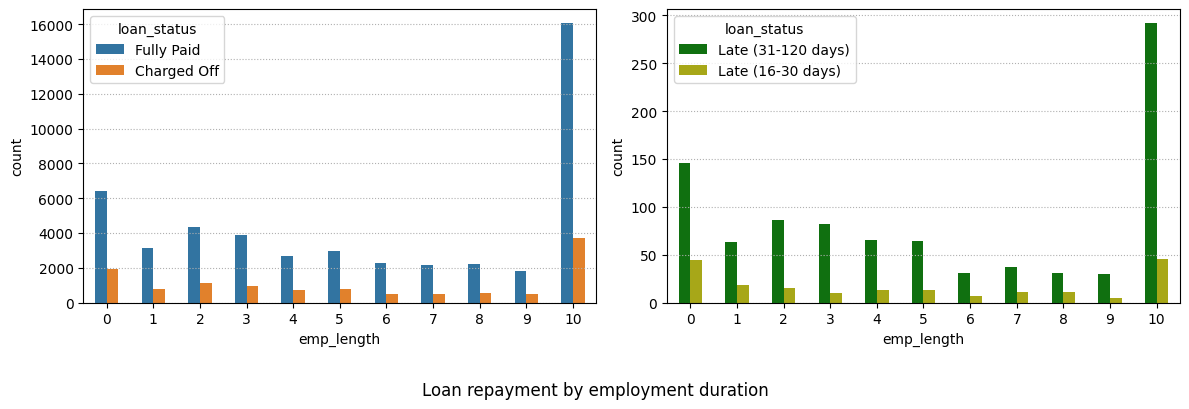

In [364]:
plot_counter = 5

fig, ax = plt.subplots(1,2, figsize=(12, 4))
fig = sns.countplot(data=temp1, x='emp_length', hue='loan_status', width=0.5, ax=ax[0])
ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

fig = sns.countplot(data=temp2, x='emp_length', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Loan repayment by employment duration', y=-0.05) #Fig.{plot_counter} - 
#ax.set_yscale('log');
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

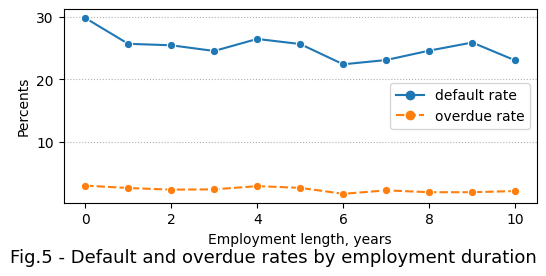

In [388]:
repaid = data[mask_paid].groupby(['emp_length'])['loan_status'].count()
default = data[mask_charged].groupby(['emp_length'])['loan_status'].count()
overdue = data[mask_overdue].groupby(['emp_length'])['loan_status'].count()

#default_rates = default / repaid
#overdue_rate = overdue / repaid

rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})

plot_counter = 5
fig, ax = plt.subplots(1,1, figsize=(5.5, 3))

plt.subplots_adjust(#left=0.1,
                    #bottom=0.2,
                    right=0.9,
                    #top=0.9,
                    wspace=0.2,
                    #hspace=0.3
                    )
sns.lineplot(rates, markers='o')
ax.set_xlabel('Employment length, years')
ax.set_ylabel('Percents')
ax.yaxis.grid(linestyle=':')
#ax.set_yscale('log')

ax.set_title(f'Fig.{plot_counter} - Default and overdue rates by employment duration', y=-0.35, fontsize=13, loc='right')
plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

### emp_title

In [366]:
get_descr('emp_title')
data['emp_title'].nunique()

The job title supplied by the Borrower when applying for the loan. Employer Title replaces Employer Name for all loans listed after 9/23/2013


29017

In [367]:
data['emp_title'] = data['emp_title'].apply(str).str.strip()

In [368]:
data['emp_title'] = data['emp_title'].apply(get_professions)
data['emp_title'].value_counts(True) #.index

skilled_laborer    0.283139
other              0.252559
manager            0.236170
employee           0.182131
executive          0.046000
Name: emp_title, dtype: float64

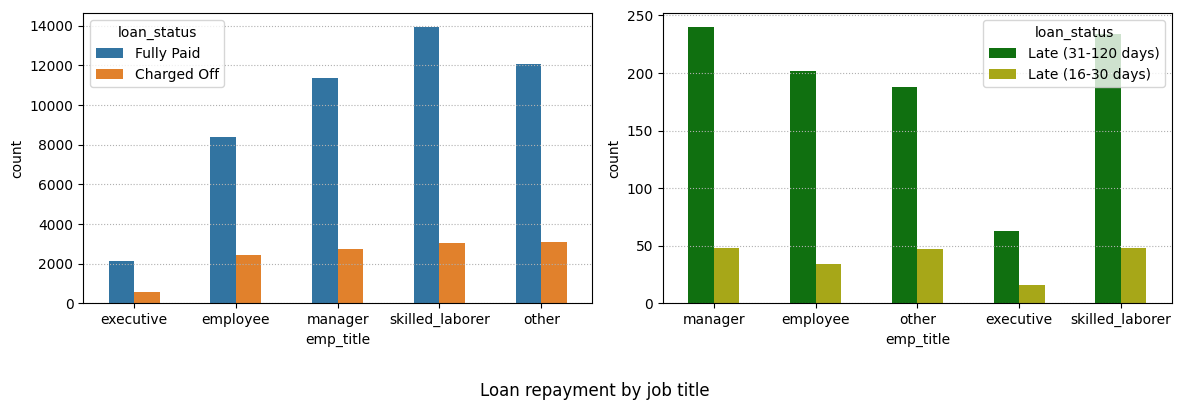

In [369]:
plot_counter = 6

temp1 = data[(mask_paid) | (mask_charged)]
temp2 = data[mask_overdue]

fig, ax = plt.subplots(1,2, figsize=(12, 4))
fig = sns.countplot(data=temp1, x='emp_title', hue='loan_status', width=0.5, ax=ax[0]) #, palette=['b','r']
ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

fig = sns.countplot(data=temp2, x='emp_title', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Loan repayment by job title', y=-0.05) #Fig.{plot_counter} - 
#ax.set_yscale('log');
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

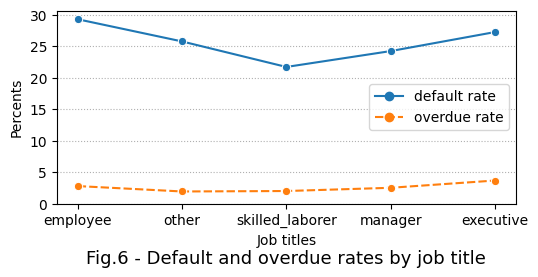

In [389]:
repaid = data[mask_paid].groupby(['emp_title'])['loan_status'].count()
default = data[mask_charged].groupby(['emp_title'])['loan_status'].count()
overdue = data[mask_overdue].groupby(['emp_title'])['loan_status'].count()

#default_rates = default / repaid
#overdue_rate = overdue / repaid

rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
}).reindex(['employee', 'other', 'skilled_laborer', 'manager', 'executive'])


plot_counter = 6
fig, ax = plt.subplots(1,1, figsize=(5.5, 3))
sns.lineplot(rates, markers='o')
ax.set_xlabel('Job titles')
ax.set_ylabel('Percents')
ax.set_title(f'Fig.{plot_counter} - Default and overdue rates by job title', y=-0.35, fontsize=13) #, loc='right'
#ax.set_yscale('log')

ax.yaxis.grid(linestyle=':')
major_ticks = np.linspace(0, 30, 7)
ax.set_yticks(major_ticks)
plt.tight_layout();
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

### home_ownership

In [371]:
data['home_ownership'].value_counts(True)

MORTGAGE    0.492782
RENT        0.399140
OWN         0.107651
ANY         0.000279
OTHER       0.000115
NONE        0.000033
Name: home_ownership, dtype: float64

In [372]:
# plot_counter = 7
# fig, ax = plt.subplots(1,2, figsize=(12, 4))
# fig = sns.countplot(data=temp1, x='home_ownership', hue='loan_status', width=0.5, ax=ax[0]) #, palette=['b','r']
# ax[0].yaxis.grid(linestyle=':')
# #ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

# fig = sns.countplot(data=temp2, x='home_ownership', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
# ax[1].yaxis.grid(linestyle=':')
# #ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

# plt.suptitle(f'Loan repayment by home ownership', y=-0.05) #Fig.{plot_counter} - 
# #ax.set_yscale('log');
# plt.tight_layout()

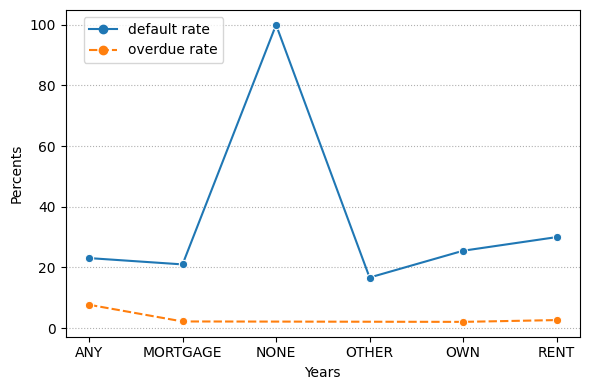

In [373]:
repaid = data[mask_paid].groupby(['home_ownership'])['loan_status'].count() #data['home_ownership']!='NONE']
default = data[mask_charged].groupby(['home_ownership'])['loan_status'].count()
overdue = data[mask_overdue].groupby(['home_ownership'])['loan_status'].count()


rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})

plot_counter = 2
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(rates, markers='o') #,  x=rates.index, y='default rate', order=3, ci=None, label='default rate'
#sns.lineplot(rates, x=rates.index, y='overdue rate', order=2, ci=None, label='overdue rate')
ax.set_xlabel('Years')
ax.set_ylabel('Percents')
ax.yaxis.grid(linestyle=':')
ax.legend(bbox_to_anchor=(.32, 1))

plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [374]:
data['home_ownership'].value_counts()

MORTGAGE    30038
RENT        24330
OWN          6562
ANY            17
OTHER           7
NONE            2
Name: home_ownership, dtype: int64

In [375]:
data['home_ownership'] = data['home_ownership'].apply(lambda x: x if x in ['MORTGAGE','RENT', 'OWN'] else 'OTHER').astype('category')

### annual_inc

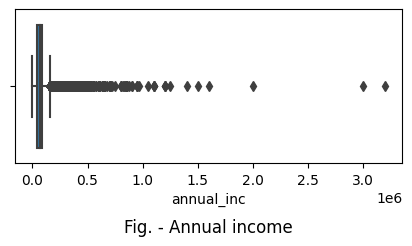

In [376]:
fig, ax = plt.subplots(figsize=(5, 2)) 
sns.boxplot(data, x='annual_inc')
#plt.tight_layout()
ax.set_title('Fig. - Annual income', y=-0.5);

In [377]:
# Logarythm of the feature
data['annual_inc_log'] = data['annual_inc'].apply(lambda x: np.log(x) if x > 0  else 0)
data['annual_inc_log'].describe()

count    60956.000000
mean        11.079399
std          0.569365
min          0.000000
25%         10.719704
50%         11.082143
75%         11.407565
max         14.978661
Name: annual_inc_log, dtype: float64

In [378]:
def get_sigma_limits(data: pd.DataFrame, features:list, sigma_factor=3):
    """Returns upper limit 

    Args:
        feature (pd.DataFrame): Feature to process
        limit
    """    
    for i, name in enumerate(features):
        mean = data[name].mean()
        std = data[name].std() 
        upper_limit = round(mean + sigma_factor* std)
        lower_limit = round(mean - sigma_factor* std)
        #print(f'Upper limit for {name} is: ', upper_limit)
        
        n_outliers = len(data[(data['annual_inc_log'] < lower_limit) | (data['annual_inc_log'] > upper_limit)].index)
        print('number of outliers: ', n_outliers)
        lower_limit = np.where(lower_limit>0, lower_limit,0)#.astype(int)
        
        limits = {'upper_limit':upper_limit,
                  'lower_limit':lower_limit,
                  'n_outliers': n_outliers}
        
    return limits

limits = get_sigma_limits(data, ['annual_inc'])
limits

number of outliers:  0


{'upper_limit': 242901, 'lower_limit': array(0), 'n_outliers': 0}

In [379]:
data.groupby('loan_status')['annual_inc'].agg(['median','mean']).round()

,median,mean
loan_status,,
Charged Off,60000.0,70229.0
Fully Paid,65000.0,77206.0
Late (16-30 days),67000.0,78217.0
Late (31-120 days),67000.0,78066.0


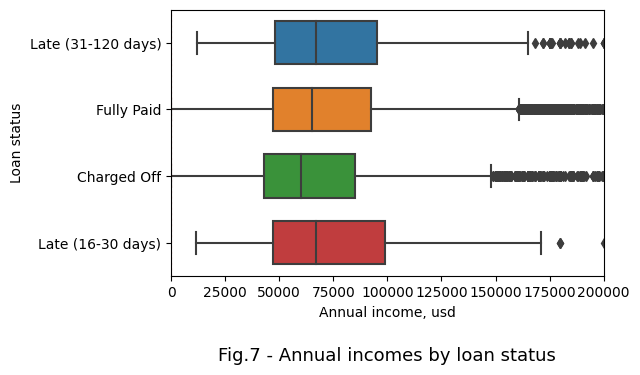

In [385]:
fig, ax = plt.subplots(1,1, figsize=(6.5, 4))
fig = sns.boxplot(data=data, x='annual_inc', y='loan_status', width=.65)
# Обозначение границы областью
# fig.add_vrect(
#     limits['lower_limit'], limits['upper_limit'],
#     fillcolor="LightSalmon", opacity=0.5,
#     layer="below", line_width=0,
#     name="Boundaries of z-method"
# )
ax.axvline(limits['lower_limit'], color='r', ls=':')
ax.axvline(limits['upper_limit'], color='r', ls=':')


plot_counter = 7
 
ax.set_xlabel('Annual income, usd')
ax.set_ylabel('Loan status')
ax.set_title(f'Fig.{plot_counter} - Annual incomes by loan status', y=-0.35, fontsize=13) #, loc='right'
#ax.set_xscale('log')
 
ax.set_xlim([0,200000])
plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [223]:
data.drop(['annual_inc'], axis=1, inplace=True)

### verification_status

In [224]:
get_descr('verification_status')

Indicates if income was verified by LC, not verified, or if the income source was verified


In [225]:
data['verification_status'].value_counts(True)

Source Verified    0.386131
Verified           0.311831
Not Verified       0.302038
Name: verification_status, dtype: float64

In [226]:
data['source_verified'] = data['verification_status'].apply(lambda x: 1 if x=='Source Verified' else 0).astype('category')
data['income_verified'] = data['verification_status'].apply(lambda x: 1 if x==' Verified' or x=='Source Verified' else 0).astype('category')

data.drop(['verification_status'], axis=1, inplace=True)

### pymnt_plan

In [227]:
get_descr('pymnt_plan')

Indicates if a payment plan has been put in place for the loan


In [228]:
data['pymnt_plan'].value_counts()

n    60926
y       30
Name: pymnt_plan, dtype: int64

### purpose

In [229]:
get_descr('purpose')


A category provided by the borrower for the loan request. 


In [230]:
data['purpose'].value_counts()

debt_consolidation    35423
credit_card           13187
home_improvement       4053
other                  3489
                      ...  
house                   375
wedding                 114
renewable_energy         36
educational              12
Name: purpose, Length: 14, dtype: int64

In [231]:
data['purpose'].value_counts().index

Index(['debt_consolidation', 'credit_card', 'home_improvement', 'other',
       'major_purchase', 'car', 'medical', 'small_business', 'moving',
       'vacation', 'house', 'wedding', 'renewable_energy', 'educational'],
      dtype='object')

In [232]:
data['purpose'] = data['purpose'].apply(get_purpose)
data['purpose'].value_counts(True) #.index

debt_consolidation    0.581124
cred_card             0.216336
house                 0.080435
other                 0.057238
                        ...   
business              0.011106
leasure               0.007005
wedding               0.001870
education             0.000197
Name: purpose, Length: 10, dtype: float64

In [233]:
#data['purpose'].value_counts().nlargest(20)

### title

In [234]:
get_descr('title')

The loan title provided by the borrower


In [235]:
data['title'].value_counts().index

Index(['Debt consolidation', 'Credit card refinancing', 'Home improvement',
       'Other', 'Major purchase', 'Debt Consolidation', 'Medical expenses',
       'Car financing', 'Business', 'Vacation',
       ...
       'Debit consolation ', 'Debt Consolidation for Amex and Discover',
       'loan 2', 'Steve's Consolidation Loan', 'BLUE INK', 'ohmlendingclub',
       'VISA Payoff', 'Debt pay', 'Home improvement Loan', 'getmycreditpay'],
      dtype='object', length=4279)

> the feature 'title' almost duplicates the feature 'purpose'

### 'installment'

In [236]:
get_descr('installment')

The monthly payment owed by the borrower if the loan originates.


The feature 'installment' is redundant since it can be calculated using formula 
$$I = \frac {P \cdot i}{1 - (1 + i)^{-n}}$$

where:
* $P$ - payment 
* $I$ - installment value, dollars
* $i$ - monthly interest rate
* $n$ - number of months

In [237]:
data.drop('installment', axis=1, inplace=True)

### 

### 'chargeoff_within_12_mths'

In [238]:
get_descr('chargeoff_within_12_mths')

Number of charge-offs within 12 months


In [239]:
data['chargeoff_within_12_mths'].unique() #.value_counts(True)

array([ 0.,  1.,  2., nan,  3.,  5.])

### 'funded_amnt'

In [240]:
get_descr('funded_amnt')

The total amount committed to that loan at that point in time.


### 'last_pymnt_d'

In [241]:
get_descr('last_pymnt_d')

Last month payment was received


In [242]:
data['last_pymnt_d'] = pd.to_datetime(data['last_pymnt_d'], errors='coerce').dt.date

In [243]:
data['last_pymnt_d'].value_counts(True)

2019-02-01    0.028828
2018-03-01    0.028763
2019-01-01    0.028302
2018-08-01    0.028269
                ...   
2008-08-01    0.000016
2009-05-01    0.000016
2009-08-01    0.000016
2008-05-01    0.000016
Name: last_pymnt_d, Length: 126, dtype: float64

### 'delinq_amnt'

In [244]:
get_descr('delinq_amnt')

The past-due amount owed for the accounts on which the borrower is now delinquent.


### 'pub_rec_bankruptcies'

In [245]:
data['pub_rec_bankruptcies'].value_counts()

0.0    53238
1.0     7206
2.0      345
3.0       98
4.0       22
5.0       11
7.0        1
6.0        1
8.0        1
Name: pub_rec_bankruptcies, dtype: int64

In [315]:
repaid = data[mask_paid].groupby(['pub_rec_bankruptcies'])['loan_status'].count() 
default = data[mask_charged].groupby(['pub_rec_bankruptcies'])['loan_status'].count()
overdue = data[mask_overdue].groupby(['pub_rec_bankruptcies'])['loan_status'].count()


bankruptcy_rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})



In [316]:
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(lambda x: 0 if x==0 else 1).astype('category')
#data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].astype('category')
#data['pub_rec_bankruptcies'].value_counts()

#data.drop(['pub_rec_bankruptcies'], axis=1, inplace=True)

> It is much easier to estimate whether or not the applicat faced default in the past using new binary feature.

### 'pub_rec'

In [248]:
get_descr('pub_rec')

Number of derogatory public records


In [249]:
data['pub_rec'].value_counts()

0.0     50592
1.0      8663
2.0      1111
3.0       338
        ...  
16.0        1
34.0        1
15.0        1
24.0        1
Name: pub_rec, Length: 16, dtype: int64

In [250]:
# repaid = data[mask_paid].groupby(['pub_rec'])['loan_status'].count() 
# default = data[mask_charged].groupby(['pub_rec'])['loan_status'].count()
# overdue = data[mask_overdue].groupby(['pub_rec'])['loan_status'].count()


# rates = pd.DataFrame({
#     'default rate': default / repaid *100, 
#     'overdue rate': overdue / repaid*100
# })

# plot_counter = 8
# fig, ax = plt.subplots(1,2, figsize=(12, 4))

# fig = sns.regplot(rates, x=rates.index, y='default rate', order=2, ci=None, label='default rate',ax=ax[0]) #, markers='o'
# fig = sns.regplot(rates, x=rates.index, y='overdue rate', order=2, ci=None, label='overdue rate',ax=ax[0])
# ax[0].set_xlabel('Number of derogatory records')
# ax[0].set_ylabel('Percents')
# ax[0].yaxis.grid(linestyle=':')

# fig = sns.regplot(bankruptcy_rates, x=bankruptcy_rates.index, y='default rate', order=2, ci=None, label='default rate', ax=ax[1]) #, markers='o'
# fig = sns.regplot(bankruptcy_rates, x=bankruptcy_rates.index, y='overdue rate', order=1, ci=None, label='overdue rate', ax=ax[1])
# ax[1].set_xlabel('Number of bankruptcies')
# ax[1].set_ylabel('Percents')
# ax[1].yaxis.grid(linestyle=':')

# plt.suptitle(f'Fig.{plot_counter} - Default and overdue rates by years since the first loan', y=-0.05, fontsize=13)#, loc='right'
# #ax.legend(bbox_to_anchor=(0.3, .8))


# #calculate slope and intercept of regression equation
# # slope, intercept, r, p, sterr = scipy.stats.linregress(x=fig.get_lines()[0].get_xdata(),
# #                                                        y=fig.get_lines()[0].get_ydata())

# #add regression equation to plot
# #plt.text(2, 95, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')

# #args = annotate_scatterplot(fig)
# #r_2 = [i[2] for i in args.values()]

# #plt.text(3, 70, f'r^2\n{(r_2[0]**2).round(2)}\n{(r_2[1]**2).round(2)}')
# plt.legend()
# plt.tight_layout()
# #plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

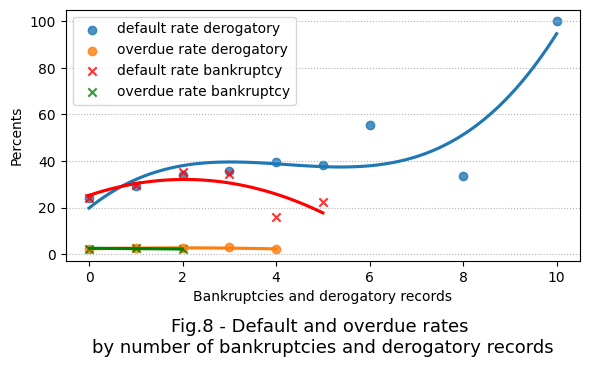

In [318]:
repaid = data[mask_paid].groupby(['pub_rec'])['loan_status'].count() 
default = data[mask_charged].groupby(['pub_rec'])['loan_status'].count()
overdue = data[mask_overdue].groupby(['pub_rec'])['loan_status'].count()


rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})

plot_counter = 8
fig, ax = plt.subplots(figsize=(6, 4))

fig = sns.regplot(rates, x=rates.index, y='default rate', order=3, ci=None, label='default rate derogatory') #, markers='o'
fig = sns.regplot(rates, x=rates.index, y='overdue rate', order=2, ci=None, label='overdue rate derogatory')
fig = sns.regplot(bankruptcy_rates, x=bankruptcy_rates.index, y='default rate', order=2, ci=None, label='default rate bankruptcy', marker='x', color='red') #, markers='o'
fig = sns.regplot(bankruptcy_rates, x=bankruptcy_rates.index, y='overdue rate', order=1, ci=None, label='overdue rate bankruptcy', marker='x', color='green')

ax.set_xlabel('Bankruptcies and derogatory records')
ax.set_ylabel('Percents')
ax.yaxis.grid(linestyle=':')


plt.title(f'Fig.{plot_counter} - Default and overdue rates \nby number of bankruptcies and derogatory records', y=-0.4, fontsize=13)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [90]:
data['pub_rec'] = data['pub_rec'].apply(lambda x: 0 if x==0 else 1).astype('category')
#data['pub_rec'] = data['pub_rec'].astype('category')

### 'earliest_cr_line'

In [91]:
get_descr('earliest_cr_line')
data['earliest_cr_line'].value_counts()

The month the borrower's earliest reported credit line was opened


Oct-2001    432
Aug-2002    431
Nov-1999    418
Sep-2003    405
           ... 
Jul-1958      1
Apr-1962      1
Aug-1963      1
Nov-1962      1
Name: earliest_cr_line, Length: 633, dtype: int64

In [92]:
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce').dt.date
data['credit_since'] = data['issued_year'] - pd.to_datetime(data['earliest_cr_line'], errors='coerce').dt.year
data['credit_since'].describe()

count    60956.000000
mean        16.278496
std          7.542712
min          3.000000
25%         11.000000
50%         15.000000
75%         20.000000
max         71.000000
Name: credit_since, dtype: float64

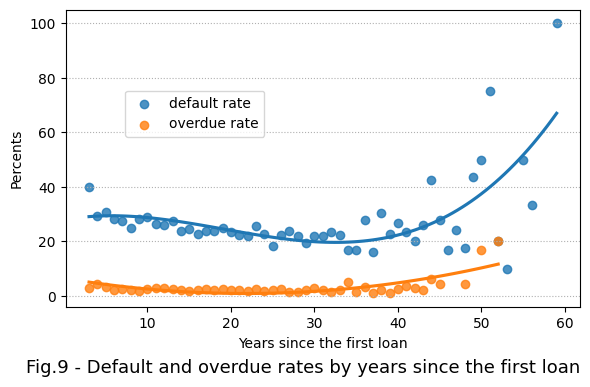

In [93]:
repaid =  data[mask_paid].groupby(['credit_since'])['loan_status'].count()
default = data[mask_charged].groupby(['credit_since'])['loan_status'].count()
overdue = data[mask_overdue].groupby(['credit_since'])['loan_status'].count()
#applications = data.groupby(['credit_since'])['loan_status'].count()

rates = pd.DataFrame({
    'default rate': default / repaid *100, 
    'overdue rate': overdue / repaid*100
})
#app =  pd.DataFrame({'applications ': applications})

plot_counter = 9
fig, ax = plt.subplots(figsize=(6, 4))

sns.regplot(rates, x=rates.index, y='default rate', order=3, ci=None, label='default rate') #, markers='o'
sns.regplot(rates, x=rates.index, y='overdue rate', order=2, ci=None, label='overdue rate')
ax.set_xlabel('Years since the first loan')
ax.set_ylabel('Percents')
ax.yaxis.grid(linestyle=':')

# ax2 = ax.twinx() 
# ax2 = sns.regplot(app, x=app.index, y=app.values, order=4, ci=None, marker='^', color='red', label='applications ') #'-o' color='red',, size=35
# ax2.set_ylabel('Annual number of applications')
#ax2.set_yscale('log')
ax.set_title(f'Fig.{plot_counter} - Default and overdue rates by years since the first loan', y=-0.25, fontsize=13, loc='right')
ax.legend(bbox_to_anchor=(0.4, .751))
# ax2.legend(bbox_to_anchor=(0.4, 0.85))
plt.tight_layout();
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

In [94]:
#data['cred_hist_less_3y'] = data['credit_since'].apply(lambda x: 1 if x<=3 else 0)
#data['cred_hist_more_35y'] = data['credit_since'].apply(lambda x: 1 if x>35 else 0)

> The feature describes number of years since the first recorded credit up to the moment when the loan was request from the company. Analyzing the fig.9 it can be said as follows:
> * the borrower's default rate substantially dropps from 40% to 30% after 3 years since the first credit and then gradually downwards to 18% unil the credit history span reaches 35 years. Then it starts to grow and fluctuating significantly.
> * similarly to the default rate, overdue rate reamins stable at 2% until the credit history span reaches 35 years, and then constanly increases by 1% annualy.

> Let us mark risky periods of the credit history: less or equal to 3 years and more than 35 years. 

###,'open_acc','revol_bal'

In [95]:
data.drop(['earliest_cr_line'],axis=1, inplace=True)

## Select columns

In [96]:
data_copy = data.query("loan_status in ['Fully Paid', 'Charged Off']")
# Delete less informative feature 'grade'
data_copy.drop(['grade'], axis=1, inplace=True) #'sub_grade'

In [97]:
selected_features = ['loan_amnt', 'term', 'int_rate', 'sub_grade', 'emp_title', 'emp_length','loan_status','home_ownership','annual_inc_log','purpose','pub_rec_bankruptcies', 'credit_since', 'source_verified','income_verified', 'pub_rec'] #'pymnt_plan''credit_since', 'grade', 'verification_status',


data_copy = data_copy[selected_features]  
data_copy.columns
# data = data[['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', \
#     'emp_title', 'emp_length','loan_status']]

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'emp_title', 'emp_length',
       'loan_status', 'home_ownership', 'annual_inc_log', 'purpose',
       'pub_rec_bankruptcies', 'credit_since', 'source_verified',
       'income_verified', 'pub_rec'],
      dtype='object')

<Axes: >

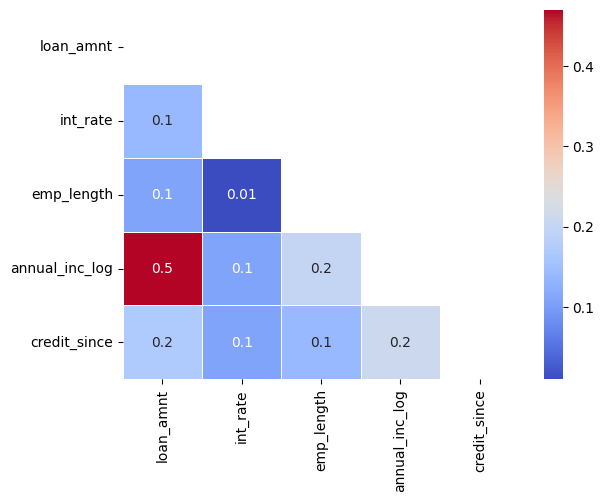

In [98]:
# heatmap

#fig = plt.figure(figsize=(30, 20))
matrix = np.triu(data_copy.corr(numeric_only=True))
sns.heatmap(round(abs(data_copy.corr(numeric_only=True)), 2), annot=True, fmt='.1g', linewidths=.5, cmap= 'coolwarm', mask=matrix)#vmin=-1, vmax=1, center= 0,


#ax.set_title('Рис. 6 - Тепловая карта корреляции переменных', y=-0.15, fontsize=12);
#ax.tick_params(axis='y', rotation=0)

## Preprocessing

In [99]:
X, y = data_copy.drop('loan_status', axis=1), data_copy['loan_status']

In [100]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_features = [s for s in X.columns if X[s].dtypes in numerics]
сat_features = [s for s in X.columns if X[s].dtypes == 'object' or X[s].dtypes == 'category']
num_features

['loan_amnt', 'int_rate', 'emp_length', 'annual_inc_log', 'credit_since']

In [101]:
сat_features

['term',
 'sub_grade',
 'emp_title',
 'home_ownership',
 'purpose',
 'pub_rec_bankruptcies',
 'source_verified',
 'income_verified',
 'pub_rec']

In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59836 entries, 1769837 to 123199
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   loan_amnt             59836 non-null  float64 
 1   term                  59836 non-null  object  
 2   int_rate              59836 non-null  float64 
 3   sub_grade             59836 non-null  object  
 4   emp_title             59836 non-null  object  
 5   emp_length            59836 non-null  int32   
 6   home_ownership        59836 non-null  category
 7   annual_inc_log        59836 non-null  float64 
 8   purpose               59836 non-null  object  
 9   pub_rec_bankruptcies  59836 non-null  category
 10  credit_since          59836 non-null  int64   
 11  source_verified       59836 non-null  category
 12  income_verified       59836 non-null  category
 13  pub_rec               59836 non-null  category
dtypes: category(5), float64(3), int32(1), int64(1),

In [103]:
X[num_features].head()

,loan_amnt,int_rate,emp_length,annual_inc_log,credit_since
1769837,20000.0,7.90,10,12.417144,52
1400202,8500.0,10.72,10,11.225243,21
1309910,18000.0,20.49,6,11.127263,11
1930865,5000.0,13.11,10,11.754302,25
1348059,14000.0,17.57,2,10.463103,9


In [104]:
X[сat_features].head()

,term,sub_grade,emp_title,home_ownership,purpose,pub_rec_bankruptcies,source_verified,income_verified,pub_rec
1769837,36_m,A4,executive,MORTGAGE,debt_consolidation,0,0,0,0
1400202,36_m,B2,employee,MORTGAGE,debt_consolidation,0,1,1,0
1309910,60_m,E2,manager,MORTGAGE,house,0,0,0,0
1930865,36_m,B4,employee,OWN,house,0,1,1,0
1348059,60_m,D2,employee,RENT,cred_card,0,1,1,0


In [105]:
transformer = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(sparse=False,drop='if_binary'), сat_features), remainder = 'passthrough') 

transformer = transformer.fit(X)
results = transformer.transform(X)
X = transformer.fit_transform(X)

X = pd.DataFrame(X, columns=transformer.transformers_[0][1].get_feature_names_out().tolist() + transformer.transformers_[1][1].get_feature_names_out().tolist())

# save columns for later usage
#imputer_columns = results.columns

In [106]:
# scaler = StandardScaler() #RobustScaler()  #MinMaxScaler() #
# X[num_features] = scaler.fit_transform(X[num_features].values)
# X

In [107]:
# # Feature encoding
# X = pd.get_dummies(X)
# X.head()

In [108]:
X['emp_length'].isna().value_counts()

False    59836
Name: emp_length, dtype: int64

## Missing values

In [109]:
X.isna().sum().value_counts(ascending=False)

0    64
dtype: int64

In [110]:
cols_null_percent = X.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null.head())

imputer =  KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# check if nan are present in the dataset
for i in X.columns:
    assert X[i].isna().sum()== 0
    
X.columns.shape

Series([], dtype: float64)

(64,)

### Target feature

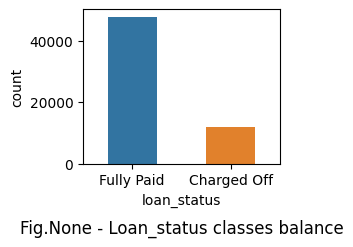

In [111]:
fig_id = None

fig, ax = plt.subplots(figsize=(3, 3)) 
sns.countplot(data=data_copy, x='loan_status', width=0.5)
ax.set_title(f'Fig.{fig_id} - Loan_status classes balance', y=-0.5)
plt.tight_layout();

#plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

#print(targets['Sales_CLoans'].value_counts(True).round(2))

In [112]:
# encoding
y = y.apply(lambda x: 1 if x=='Fully Paid' else 0)

unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0 1] [11940 47896]


In [113]:
X_copy, y_copy = X.copy(), y.copy()

### balancing classes

In [114]:
# Synthetic resampling of minority class
sm = SMOTE(random_state=random_seed)
X_copy, y_copy = sm.fit_resample(X_copy, y_copy)

unique, counts = np.unique(y_copy, return_counts=True)
print('After synthetic resampling : ',unique, counts)

After synthetic resampling :  [0 1] [47896 47896]


# 2. Modelling

In [115]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_copy, y_copy, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (76633, 64)
Test shape:  (9579, 64)
Valid shape: (9580, 64)


In [116]:
models_dict = dict()

### Random forest

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      4878
           1       0.70      0.69      0.70      4701

    accuracy                           0.71      9579
   macro avg       0.71      0.71      0.71      9579
weighted avg       0.71      0.71      0.71      9579

roc_auc:  0.778


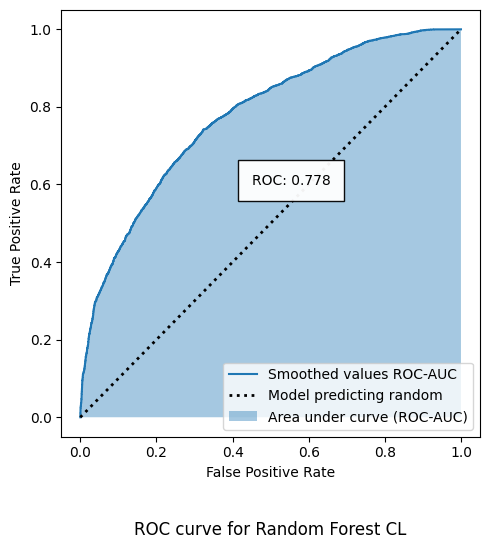

In [117]:
rf = RandomForestClassifier(
    n_estimators=110, 
    min_samples_leaf=5,
    max_depth=7,
    #verbose=1, 
    n_jobs=-1, 
    random_state=random_seed)

#Train model
rf.fit(X_train, y_train)

# Prediction
y_pred = rf.predict(X_test)

# Save results
models_dict.update({'random_forest':rf})

print(classification_report(y_test, y_pred))

get_ROC_plot(rf, X_test, y_test, 'Random Forest CL')

### Gradient boosting

In [118]:
# gb = GradientBoostingClassifier(
#     learning_rate=0.01,
#     n_estimators=95,
#     min_samples_leaf=3,
#     max_depth=3,
#     random_state=random_seed
# )

# # train model
# gb.fit(X_train, y_train)
 
# # Predict target values
# y_pred = gb.predict(X_test)

# # Metrics report
# print(classification_report(y_test, y_pred))

# # Save results
# models_dict.update({'gradient_boosting':gb})

# get_ROC_plot(gb, X_test, y_test, 'Gradient Boosting CL')

In [119]:
# from sklearn.metrics import confusion_matrix 
# print(confusion_matrix(y_test, y_pred))

## Models Comparison

In [120]:
# # Save model to the given path in the pkl format
# model_name = 'gbr_cl'
# full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
# #models_dict.update({'Revenue_CLoans':model_name})

# with open(full_path, 'wb') as f:
#     pickle.dump(gbr_cl, f)

## Other

### Gradient boosting + Optuna

In [121]:
def optuna_gb(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 300, 350, 1)
    max_depth = trial.suggest_int('max_depth', 5, 10, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    
    # model creation 
    model = GradientBoostingClassifier(
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=random_seed)
    
    # training
    model.fit(X_train, y_train)
    y_pred = np.round(model.predict_proba(X_test)[:,1])
    F1_score = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred)
    
    return F1_score, roc_score

#%%time
sampler = TPESampler(seed=random_seed) # fix random seed

# create study set
study = optuna.create_study(study_name="GBClassifier", directions=["maximize", "maximize"], sampler=sampler)
# try multiple times
study.optimize(optuna_gb, n_trials=5)
clear_output(wait=False)

optuna.visualization.plot_pareto_front(study, target_names=["F1_score", "roc_score"])

In [122]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

best_hyperparameters = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {best_hyperparameters.number}")
print(f"\tparams: {best_hyperparameters.params}")
#print(f"\tvalues: {best_hyperparameters.values}")

Number of trials on the Pareto front: 1
Trial with highest accuracy: 
	params: {'n_estimators': 319, 'max_depth': 10, 'min_samples_leaf': 4, 'learning_rate': 0.0638792635777333}


              precision    recall  f1-score   support

           0       0.95      0.77      0.85      4878
           1       0.80      0.95      0.87      4701

    accuracy                           0.86      9579
   macro avg       0.87      0.86      0.86      9579
weighted avg       0.88      0.86      0.86      9579

roc_auc:  0.922


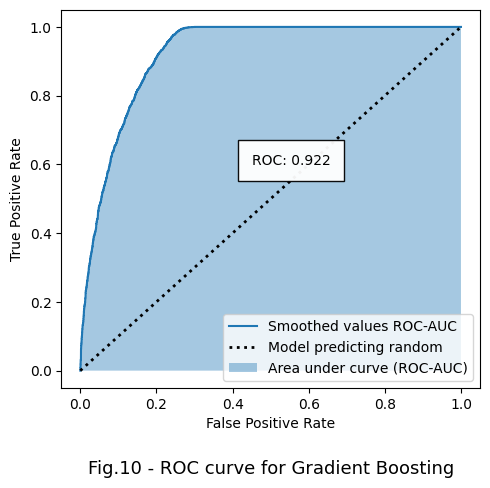

In [123]:
# Apply best parameters
gb_opt_cl = GradientBoostingClassifier(**best_hyperparameters.params, random_state=random_seed) #study.best_params
gb_opt_cl.fit(X_train, y_train)

# Predict target values
y_pred_gb_optu = gb_opt_cl.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb_optu))

# Save results
models_dict.update({'g_boosting_opt':gb_opt_cl})

get_ROC_plot(gb_opt_cl, X_test, y_test, 'Gradient Boosting', plot_counter=10)  # + Optuna for CL

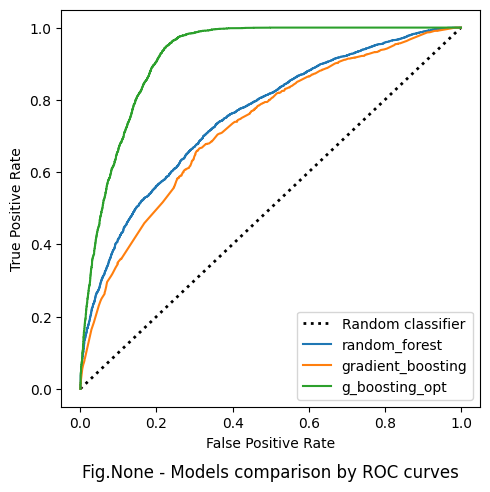

In [ ]:
get_comparison(models_dict, X_test, y_test)

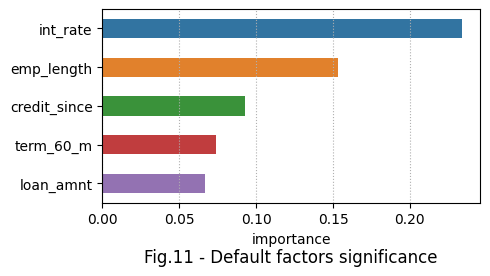

In [124]:
factors = pd.DataFrame({'importance':gb_opt_cl.feature_importances_}, index=X_train.columns).sort_values(by='importance', ascending=False).iloc[:5]

plot_counter=11

# display first 7 most significant features
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='importance', y=factors.index, width=0.5)
ax.set_title(f'Fig.{plot_counter} - Default factors significance', y=-0.35); 
plt.tight_layout()
ax.xaxis.grid(linestyle=':');

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

# 3. Interest rate modelling

### Check for multicollinearity

In [125]:
X, y = data_copy.drop(['int_rate','loan_status', 'sub_grade'], axis=1), np.log(data_copy['int_rate'])  #, , np.log(data['int_rate'] # 'grade'

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_features = [s for s in X.columns if X[s].dtypes in numerics]
сat_features = [s for s in X.columns if X[s].dtypes == 'object' or X[s].dtypes == 'category']
num_features

transformed_features = X.columns
transformed_features

Index(['loan_amnt', 'term', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc_log', 'purpose', 'pub_rec_bankruptcies', 'credit_since',
       'source_verified', 'income_verified', 'pub_rec'],
      dtype='object')

In [126]:
transformer1 = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(sparse=False,drop='if_binary'), сat_features), remainder = 'passthrough') 

transformer1 = transformer1.fit(X)
results = transformer1.transform(X)

results = pd.DataFrame(results, columns=transformer1.transformers_[0][1].get_feature_names_out().tolist() + transformer1.transformers_[1][1].get_feature_names_out().tolist())

# save columns for later usage
imputer_columns = results.columns

In [127]:
# check for missing values
imputer =  KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
X = pd.DataFrame(imputer.fit_transform(results), columns=imputer_columns)

# check if nan are present in the dataset
for i in X.columns:
    assert X[i].isna().sum()== 0

### Check for multicollinearity

In [128]:
# select features with correlation coefficient > 0.7
pivot = X.corr()

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

high_correlation_features = list(pivot.columns) # список признаков c высокой корреляцией
pivot 

print('Features with high correlation coef:')
for count, value in enumerate(high_correlation_features, start=1): # list features from 1
    print(count, value)

Features with high correlation coef:
1 home_ownership_MORTGAGE
2 home_ownership_RENT
3 pub_rec_bankruptcies_1
4 pub_rec_1


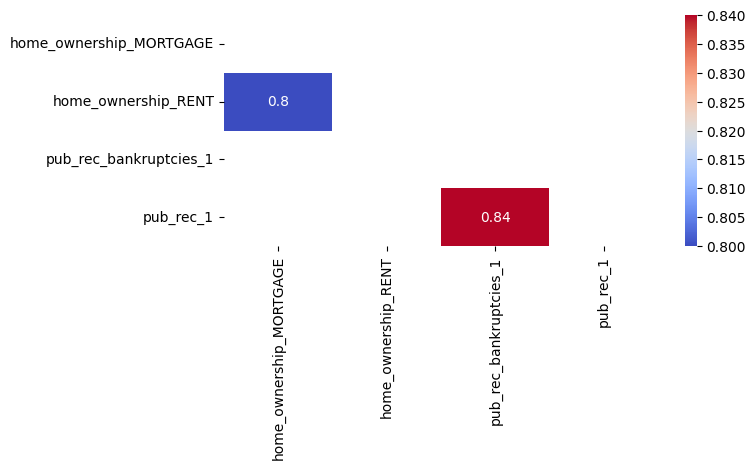

In [129]:
# heatmap
fig = plt.figure(figsize=(7, 3))
matrix = np.triu(pivot)
sns.heatmap(round(abs(pivot), 2), annot=True, cmap= 'coolwarm', mask=matrix);

In [130]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (47868, 28)
Test shape:  (5984, 28)
Valid shape: (5984, 28)


In [131]:
X.head(2)

,loan_amnt,emp_length,annual_inc_log,credit_since,...,pub_rec_bankruptcies_1,source_verified_1,income_verified_1,pub_rec_1
0,0.649080,1.134998,2.348576,4.737288,...,0.0,0.0,0.0,0.0
1,-0.677496,1.134998,0.257095,0.625482,...,0.0,1.0,1.0,0.0


## Linear models

In [132]:
# # Creation an instance
# lin_cl = LinearRegression()

# # Train the Model
# lin_cl.fit(X_train, y_train)

# # Predict target values
# y_pred_lin = lin_cl.predict(X_test)

# print(f'MSE: {round(mean_squared_error(y_test, y_pred_lin),2)}')
# print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lin)*100,2)} %')

### Linear regression with Stochastic gradient descent

In [133]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# Creation an instance
lin_sgd = linear_model.SGDRegressor(random_state=random_seed)

# Train the Model
lin_sgd.fit(X_train, y_train)

# Predict target values
y_pred_train, y_pred_test = lin_sgd.predict(X_train), lin_sgd.predict(X_test)
 

print(f'MSE: {round(mean_squared_error(y_test, y_pred_test),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_test)*100,2)} %')

print("Train R^2: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_pred_test)))

MSE: 0.1
MAPE: 10.46 %
Train R^2: 0.246
Test R^2: 0.258


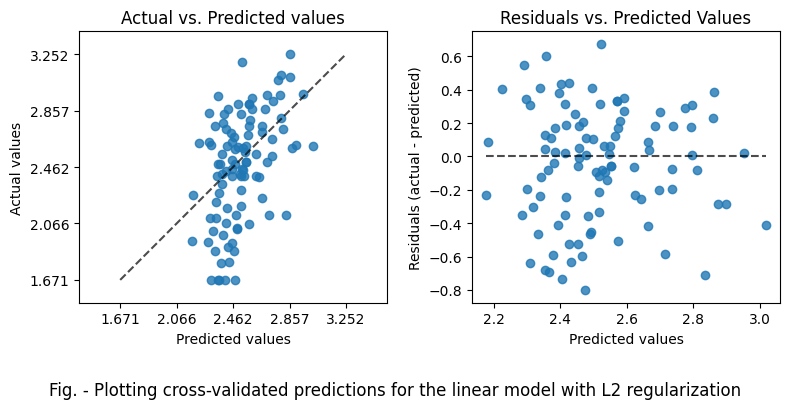

In [134]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions for the linear model with L2 regularization", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');


In [135]:
# Features and coefficients
coef_df = pd.DataFrame({'Coefficients': lin_sgd.coef_}, index=X_train.columns)
coef_df
# add the intercept coefficient
coef_df.loc['INTERCEPT'] = lin_sgd.intercept_
display(coef_df.sort_values('Coefficients',ascending=False))

,Coefficients
INTERCEPT,1.514019
home_ownership_RENT,0.516305
home_ownership_OWN,0.486766
home_ownership_MORTGAGE,0.451484
...,...
purpose_education,0.003199
pub_rec_bankruptcies_1,0.001082
credit_since,-0.050871
annual_inc_log,-0.051182


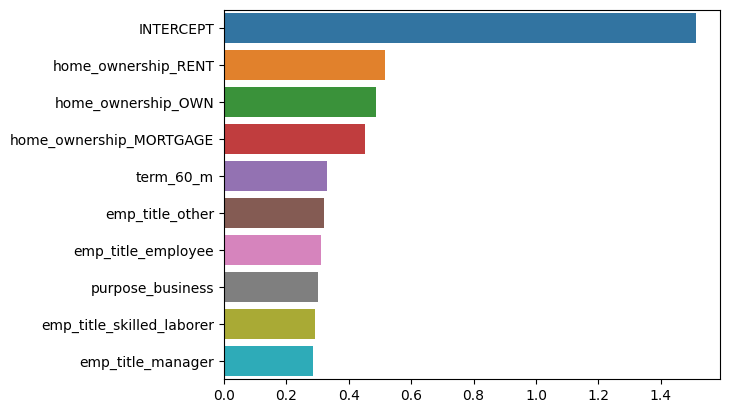

In [136]:
temp = coef_df.sort_values('Coefficients',ascending=False)
sns.barplot(x=temp.values.flatten()[:10], y=temp.index[:10])
plt.show()

> The variance of the model is not constant across various levels of the predicted variable. It means that the model fails to predict low and high interst rates.

### Regularization

In [137]:
# Creation an instance
lasso_lr_poly = linear_model.Lasso(alpha=0.005, random_state=random_seed)

# Train the Model
lasso_lr_poly.fit(X_train, y_train)

# Predict target values
y_pred_lin = lasso_lr_poly.predict(X_test)

print(f'MSE: {round(mean_squared_error(y_test, y_pred_lin),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lin)*100,2)} %')

MSE: 0.1
MAPE: 10.55 %


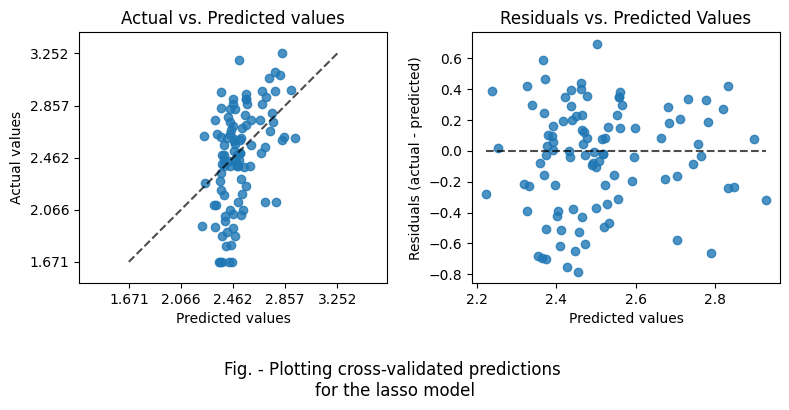

In [138]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lin,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lin,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions \nfor the lasso model", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

### Polynomial

In [139]:
from sklearn.preprocessing import PolynomialFeatures
# Creation an instance
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)

# Generation of polynomial features for samples
X_train_poly, X_test_poly, X_valid_poly = poly.transform(X_train), poly.transform(X_test), poly.transform(X_valid)


#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)


(47868, 434)
(5984, 434)


In [140]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# Creation an instance
lin_poly = linear_model.SGDRegressor(random_state=random_seed)

# Train the Model
lin_poly.fit(X_train, y_train)

# Predict target values
y_train_pred_poly, y_test_pred_poly = lin_poly.predict(X_train), lin_poly.predict(X_test)

print(f'MSE: {round(mean_squared_error(y_test, y_test_pred_poly),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_test_pred_poly)*100,2)} %')

# print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_pred_poly)))
# print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_pred_poly)))

MSE: 0.1
MAPE: 10.46 %


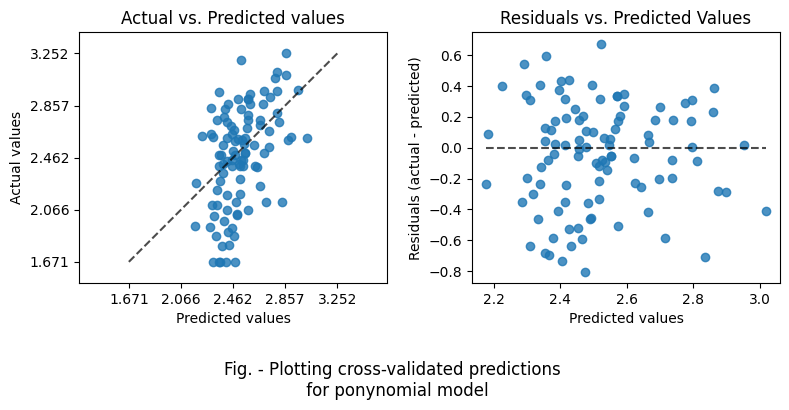

In [141]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred_poly,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred_poly,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions \n for ponynomial model", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

In [142]:
# Features and coefficients
coef_df = pd.DataFrame({'Coefficients': lin_poly.coef_}, index=X_train.columns)
coef_df
# add the intercept coefficient
coef_df.loc['INTERCEPT'] = lin_poly.intercept_
display(coef_df.sort_values('Coefficients',ascending=False))

,Coefficients
INTERCEPT,1.514019
home_ownership_RENT,0.516305
home_ownership_OWN,0.486766
home_ownership_MORTGAGE,0.451484
...,...
purpose_education,0.003199
pub_rec_bankruptcies_1,0.001082
credit_since,-0.050871
annual_inc_log,-0.051182


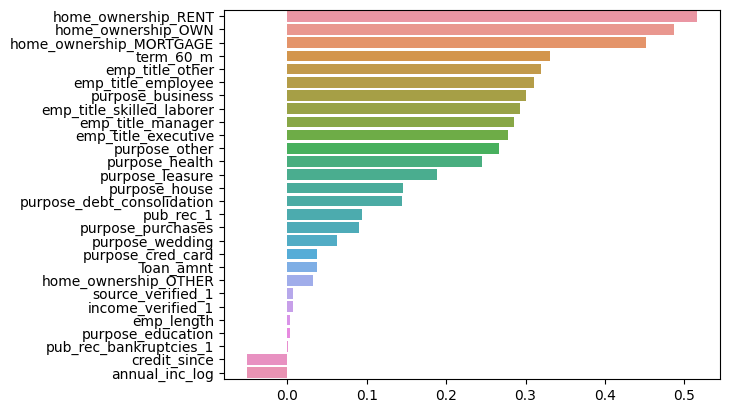

In [143]:
aa= coef_df.sort_values('Coefficients',ascending=False)[1:]
sns.barplot(x=aa.values.flatten(),y=aa.index)
plt.show()

### Gradient boosting

In [144]:
gbr_cl = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=300,
    random_state=random_seed 
)
# Model training
gbr_cl.fit(X_train, y_train)

# Predict target values
y_pred_train, y_pred_test = gbr_cl.predict(X_train), gbr_cl.predict(X_test)
 

print(f'MSE: {round(mean_squared_error(y_test, y_pred_test),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_test)*100,2)} %')

print("Train R^2: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_pred_test)))

MSE: 0.09
MAPE: 10.03 %
Train R^2: 0.374
Test R^2: 0.314


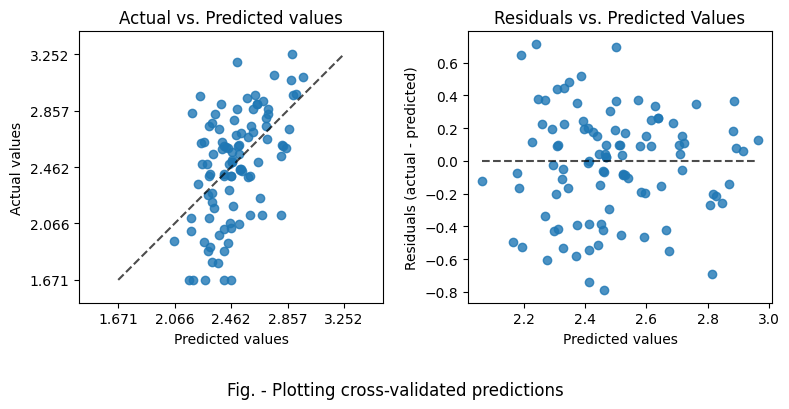

In [145]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

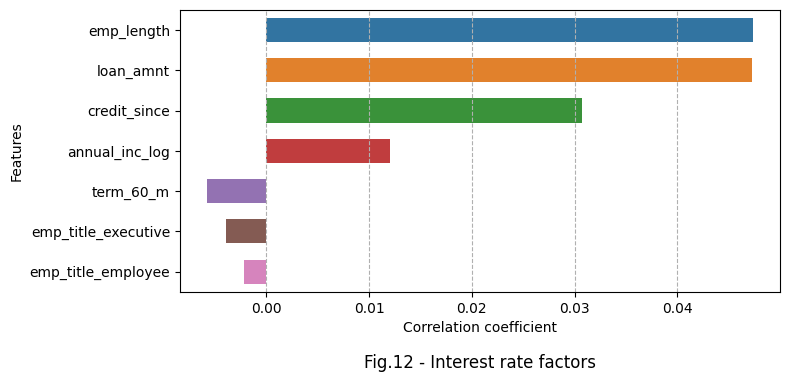

In [146]:
# correlation scores with the dependent variable
corr_df = X.corrwith(data['int_rate'], method='pearson')
corr_df = pd.DataFrame({'corr_value':corr_df}).iloc[:7]

corr_df.sort_values(by='corr_value', key=abs, ascending=False, inplace=True)#.round(2).to_dict()

plot_counter = 12
fig, ax = plt.subplots(figsize=(8, 4))
hist = sns.barplot(corr_df, x='corr_value' , y=corr_df.index, width=0.6);

hist.set(xlabel='Correlation coefficient', ylabel='Features')
ax.set_title(f'Fig.{plot_counter} - Interest rate factors', y=-0.3);
#major_ticks = np.linspace(-0.1, 0.1, 3)
#ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout()

plt.savefig(os.path.join(path_figures + f'fig_{plot_counter}.png'))

## Model comparison

In [147]:
# Save model to the given path in the pkl format
model_name = 'gbr_cl'
full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
#models_dict.update({'Revenue_CLoans':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gbr_cl, f)

In [148]:
data.head(1)

,loan_amnt,funded_amnt,funded_amnt_inv,term,...,annual_inc_log,source_verified,income_verified,credit_since
782893,25000.0,25000.0,25000.0,36_m,...,12.611538,1,1,20


In [149]:
corr_df.sort_values(by='corr_value', key=abs, ascending=False).index

Index(['emp_length', 'loan_amnt', 'credit_since', 'annual_inc_log',
       'term_60_m', 'emp_title_executive', 'emp_title_employee'],
      dtype='object')

# 4. Expected revenue estimation 

In [150]:
# current clients
data_c = current.copy() 

def dataset_preprocessing(data:pd.DataFrame)->pd.DataFrame:
    data = data[selected_cols]
    
    data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.date
    data['issued_year'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.year
    data['term'] = data['term'].replace({' 36 months': '36_m', ' 60 months': '60_m'})
    
    # employment length
    data['emp_length'] = data['emp_length'].apply(lambda x: str(x).replace('+ years', '')\
        .replace(' years', '').replace('< 1 year', '0')).replace('1 year', '1').replace('nan','-1').astype('int')
    data['emp_length'].replace(-1, 0, inplace=True)
    # professions
    data['emp_title'] = data['emp_title'].apply(str).str.strip()
    data['emp_title'] = data['emp_title'].apply(get_professions)
    
    # home ownership
    data['home_ownership'] = data['home_ownership'].apply(lambda x: x if x in ['MORTGAGE','RENT', 'OWN'] else 'OTHER').astype('category')
    
    
    # logarythm of the income
    data['annual_inc_log'] = data['annual_inc'].apply(lambda x: np.log(x) if x > 0  else 0)

    # binarization of the verrification status
    data['source_verified'] = data['verification_status'].apply(lambda x: 1 if x=='Source Verified' else 0).astype('category')
    data['income_verified'] = data['verification_status'].apply(lambda x: 1 if x==' Verified' or x=='Source Verified' else 0).astype('category')
    
    # purpose
    data['purpose'] = data['purpose'].apply(get_purpose)
    
    # bankruptcies
    data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(lambda x: 0 if x==0 else 1).astype('category')

    # credit history
    data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce').dt.date
    data['credit_since'] = data['issued_year'] - pd.to_datetime(data['earliest_cr_line'], errors='coerce').dt.year
    
    # Number of derogatory public records
    data['pub_rec'] = data['pub_rec'].apply(lambda x: 0 if x==0 else 1).astype('category')

    data.drop(['annual_inc', 'verification_status', 'installment'],axis=1, inplace=True) #'issue_d'
    
    return data #[selected_features]

data_c = dataset_preprocessing(data_c)
data_c = data_c[selected_features]
data_c.columns

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'emp_title', 'emp_length',
       'loan_status', 'home_ownership', 'annual_inc_log', 'purpose',
       'pub_rec_bankruptcies', 'credit_since', 'source_verified',
       'income_verified', 'pub_rec'],
      dtype='object')

In [151]:
data_c = data_c[selected_features]
print(data_c.shape)

temp = transformer.transform(data_c)

# apply all preprocessings
data_c = pd.DataFrame(temp, columns=transformer.transformers_[0][1].get_feature_names_out().tolist() + transformer.transformers_[1][1].get_feature_names_out().tolist())
print(data_c.shape)

(38550, 15)
(38550, 64)


In [152]:
result = data_c.copy()
result['loan_amnt'] = current['loan_amnt'].values
result['int_rate'] = current['int_rate'].values
result['default_expected'] = rf.predict(data_c)
result['expected_revenue'] = result['loan_amnt'] * 0.01*result['int_rate']
result['forecasted_revenue'] = result['expected_revenue'] * result['default_expected']
result['after_cleaning'] = result['forecasted_revenue'].apply(lambda x: x if x>0 else None)
result[['loan_amnt', 'default_expected', 'expected_revenue','forecasted_revenue']]

,loan_amnt,default_expected,expected_revenue,forecasted_revenue
0,14000.0,1,1505.0,1505.0
1,15000.0,1,3133.5,3133.5
2,20000.0,0,3204.0,0.0
3,13000.0,0,1558.7,0.0
...,...,...,...,...
38546,35000.0,1,4896.5,4896.5
38547,20000.0,1,2212.0,2212.0
38548,20000.0,1,2112.0,2112.0
38549,13000.0,1,1753.7,1753.7


In [153]:
result[['forecasted_revenue', 'after_cleaning']].describe()

,forecasted_revenue,after_cleaning
count,38550.000000,24259.000000
mean,902.192338,1433.674704
std,1096.569131,1071.849537
min,0.000000,53.200000
25%,0.000000,654.900000
50%,592.200000,1138.800000
75%,1375.500000,1899.000000
max,10846.500000,10846.500000


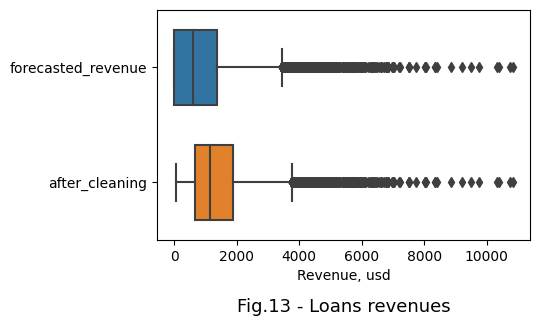

In [154]:
fig, ax = plt.subplots(1,1, figsize=(5.5, 3.5))
fig = sns.boxplot(data=result[['forecasted_revenue','after_cleaning']], orient='h',  width=.65)

plot_counter = 13
 
ax.set_xlabel('Revenue, usd')
#ax.set_ylabel('Scenario')
ax.set_title(f'Fig.{plot_counter} - Loans revenues', y=-0.35, fontsize=13) #, loc='right'
['Current', 'Proposed']
#ax.set_xscale('log')
 
#ax.set_xlim([0,200000])
plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));